### Notebook that calculate the ratio of driver mutations involved in UPS (E3 ligases drivers and degron drivers) compared to the total of driver mutations(from dnds paper, 369 genes + all drivers considered in the UPs analysis) 

### Read data 

In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import numpy as np, scipy.stats as st
import itertools

### paths

In [2]:
base = "../../"
# Path dndscv of global run
path_output_methods=os.path.join(base,"data","output_methods_selection")
path_dndscv = os.path.join(path_output_methods,"output_dndscv_e3ligases_paper_tcga_tri")
# Path drivers
path_drivers_tables3 = os.path.join(base,"internal","Table_S3_dNdScv.txt")
# Path E3 ligases
df_drivers_tcga = pd.read_csv( os.path.join(base,"data","signals_E3_ligases_tcga.tsv"),sep="\t")
drivers_e3_tcga = list(df_drivers_tcga[(df_drivers_tcga["oncodrivefml_qvalue"]<0.1)|(df_drivers_tcga["dndscv_qvalue"]<0.1)]["Hugo_Symbol"].unique())
path_dictionary_samples_e3 = os.path.join(base,"data","dict_excess_per_sample_E3s.json")
# Path driver degrons
path_output_drivers_strict_tcga = os.path.join(base,"data","list_drivers_degrons_strict_tcga.txt")
path_dictionary_samples_degron = os.path.join(base,"data","dict_excess_per_sample_degrons.json")
#Path input mutations (count samples)
path_input_muts = os.path.join(base,"data","mutations_e3","tcga")
# Plots 
path_output_plots = os.path.join(base,"plots","Figure7")


In [3]:
import re

def read_drivers(file_path):
    f = open(file_path,'r')
    drivers = set()
    for line in f.readlines():
        line = line.strip()
        for gene in re.split(r'\t+', line):
            drivers.add(gene)
    f.close()
    return drivers
driver_degrons=list(read_drivers(path_output_drivers_strict_tcga))

### Read All Driver elements

In [12]:
# Read driver genes N 369
drivers_total = []
f = open(path_drivers_tables3,'r')
for line in f:
    line = line.strip()
    drivers_total = line.split("\t")

drivers = list(set(drivers_total + drivers_e3_tcga + driver_degrons))

len(drivers)

411

### Numbers

### Get number of samples analyzed per tumor

In [13]:
path_dndscv

'../../data/output_methods_selection/output_dndscv_e3ligases_paper_tcga_tri'

In [14]:
dict_samples= {}
for filef in glob.glob(path_input_muts+"/"+"*_dndscv.tsv.gz"):
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    ttype = os.path.basename(filef).split(".")[0].split("_")[0]
    df["Cancer_Type"]=ttype
    dict_samples[ttype]=len(df["sampleID"].unique())

In [15]:
dict_samples

{'ACC': 90,
 'BLCA': 406,
 'BRCA': 786,
 'CESC': 279,
 'CHOL': 36,
 'COADREAD': 328,
 'DLBC': 37,
 'ESCA': 182,
 'GBM': 312,
 'HNSC': 504,
 'KICH': 66,
 'KIRC': 368,
 'KIRP': 281,
 'LGG': 510,
 'LIHC': 361,
 'LUAD': 507,
 'LUSC': 476,
 'MESO': 81,
 'OV': 65,
 'PAAD': 176,
 'PAN': 8899,
 'PCPG': 179,
 'PRAD': 494,
 'SARC': 234,
 'SKCM': 450,
 'STAD': 392,
 'TGCT': 145,
 'THCA': 492,
 'THYM': 122,
 'UCEC': 404,
 'UCS': 56,
 'UVM': 80}

### Read output of dndscv and get the global value of dndscv

##### Functions to calculate excess from omega

In [16]:
def excess_muts(n_obs, omega):
    """
    n_obs: int: number of observed mutations of a kind
    omega: float: applicable dnds estimate
    omega: float: applicable dnds estimate
    """
    if (n_obs == 0) or np.isnan(n_obs) or np.isnan(omega):
        return n_obs
    elif 0 <= omega <= 1:
        return 0
    elif omega > 1:
        return round((omega - 1) * n_obs / omega)

def excess_rate(n_obs, omega):
    """
    n_obs: int: number of observed mutations of a kind
    omega: float: applicable dnds estimate
    """
    if (n_obs == 0) or np.isnan(n_obs) or np.isnan(omega):
        return 0
    elif 0 <= omega <= 1:
        return 0
    elif omega > 1:
        return (omega - 1) / omega

def add_excess(df):
    df['excess_mis'] = df.apply(lambda v: excess_muts(v['n_mis'], v['wmis_cv']), axis=1)
    df['excess_non'] = df.apply(lambda v: excess_muts(v['n_non'], v['wnon_cv']), axis=1)
    df['excess_spl'] = df.apply(lambda v: excess_muts(v['n_spl'], v['wspl_cv']), axis=1)
    df['excess_rate_mis'] = df.apply(lambda v: excess_rate(v['n_mis'], v['wmis_cv']), axis=1)
    df['excess_rate_non'] = df.apply(lambda v: excess_rate(v['n_non'], v['wnon_cv']), axis=1)
    df['excess_rate_spl'] = df.apply(lambda v: excess_rate(v['n_spl'], v['wspl_cv']), axis=1)
    return df


### Calculate the excess per cohort per gene

In [17]:
l = []
for filef in glob.glob(path_dndscv+"/*.out.gz"):
    if "annotmuts" in filef or "genemuts" in filef:
        continue
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    

    ttype = os.path.basename(filef).split(".")[0]
    df["Cancer_Type"]=ttype

    df = df[df["gene_name"].isin(drivers)][['gene_name', 'wmis_cv', 'wnon_cv', 'wspl_cv', 'n_mis', 'n_syn', 'n_spl', 'n_non','Cancer_Type']].drop_duplicates()
    #df.rename(columns={"qglobal_cv":"dndscv_qvalue","gene_name":"Hugo_Symbol"},inplace=True)
    l.append(df)
df_dnds = pd.concat(l)
df_with_excess = add_excess(df_dnds)

### Dictionaries to speed up the calculation of sample-specific excess

In [18]:
dict_missense = {}
dict_non = {}
dict_splice = {}
d_global = {}
for index,row in df_with_excess.iterrows():
    dict_missense[row["gene_name"]+"_"+row["Cancer_Type"]] = row["excess_rate_mis"]
    dict_non[row["gene_name"]+"_"+row["Cancer_Type"]] = row["excess_rate_non"]
    dict_splice[row["gene_name"]+"_"+row["Cancer_Type"]] = row["excess_rate_spl"]
d_global["Missense"] = dict_missense
d_global["Nonsense"] = dict_non
d_global["Essential_Splice"] = dict_splice

### Calculate for each sample the number of driver mutations (number of mutations in excess). Calculate per consequence type and the agggregated one

##### Functions to calculate it

In [19]:
def get_excess_sample(df_grouped,impact,total_samples,ttype,dict_output,dict_samples):
    '''
    df_grouped : dataframe input with the excess grouped by sample, gene and impact. The column pos has the number of mutations per gene per sample. 
    impact: consequence type ["Missense","Nonsense","Essential_Splice"]
    total_samples: total number of samples in this cohrot
    ttype: cancer type
    dict_output: dictionary to fill with the excess of the impact type for this cohort
    dict_samples: diciontary where keys are ttype and samples where its calculated the global excess (excess of mis, non and splice) per sample 
    '''
    df_data = df_grouped[df_grouped["impact"]==impact]

    excess_array = []
    if df_data.shape[0] >0:
        
        # calculate excess as excess_rate * number of mutations per gene per sample
        df_data["excess"]=df_data.apply(lambda row: row["pos"]*d_global[impact][row["gene"]+"_"+row["Cancer_Type"]],axis=1)
        # get sum of missense in excess per sample
        excess_array = list(df_data.groupby("sampleID",as_index=False).agg({"excess":np.nansum})["excess"].values)
        samples = list(df_data.groupby("sampleID",as_index=False).agg({"excess":np.nansum})["sampleID"].values)
        for i in range(0,len(samples)):
            sample = samples[i]
            if sample in dict_samples[ttype]:
                dict_samples[ttype][sample] =  dict_samples[ttype][sample] + excess_array[i]
            else:
                dict_samples[ttype][sample] =  excess_array[i]
        
    # if there is not information is a 0
    zeros = list(np.zeros(total_samples-len(excess_array)))
    total_cohort = zeros +  excess_array
    if not(ttype in dict_output):
        dict_output[ttype]= []
    dict_output[ttype] = dict_output[ttype] + total_cohort
    return dict_output,dict_samples

### Perform the calculation for all tumor types

In [20]:
dict_excess_sample_missense = {}
dict_excess_sample_nonsense = {}
dict_excess_sample_splice = {}
dict_excess_sample_aggregated = {}
dict_samples_local = {}
for filef in glob.glob(path_dndscv+"/*.annotmuts.out.gz"):
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    df = df[df["gene"].isin(drivers)]

    ttype = os.path.basename(filef).split(".")[0]
    df["Cancer_Type"]=ttype
    if ttype == "COAD" or ttype == "READ":
        continue # Its grouped in COADREAD
    # Get total number of samples
    total_samples = dict_samples[ttype]
    
    dict_samples_local[ttype] = {}
    # Group per sample and gene
    df_grouped = df.groupby(["Cancer_Type","gene","sampleID","impact"],as_index=False).agg({"pos":"count"}) # count mutations in gene per sample
    # Missense
    dict_excess_sample_missense,dict_samples_local=get_excess_sample(df_grouped,"Missense",total_samples,ttype,dict_excess_sample_missense,dict_samples_local)
    # Nonsense
    dict_excess_sample_nonsense,dict_samples_local=get_excess_sample(df_grouped,"Nonsense",total_samples,ttype,dict_excess_sample_nonsense,dict_samples_local)
    # Splice
    dict_excess_sample_splice,dict_samples_local=get_excess_sample(df_grouped,"Essential_Splice",total_samples,ttype,dict_excess_sample_splice,dict_samples_local)
    # dict aggregated
    excess_aggregated_data = list(dict_samples_local[ttype].values())
    zeros = list(np.zeros(total_samples-len(excess_aggregated_data)))
    dict_excess_sample_aggregated[ttype] = list(excess_aggregated_data) + zeros

    


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
for ttype in dict_excess_sample_aggregated.keys():
    aggregated = np.nanmean(dict_excess_sample_aggregated[ttype])
    mis = np.nanmean(dict_excess_sample_missense[ttype])
    non = np.nanmean(dict_excess_sample_nonsense[ttype])
    spl = np.nanmean(dict_excess_sample_splice[ttype])
    print (ttype,aggregated,mis,non,spl)

GBM 2.561265924234731 2.1201419744908727 0.32355088306892965 0.11757306667492909
OV 2.6567487345594816 2.2049206893697146 0.31687843293936147 0.13494961225040547
LUAD 4.677765454699669 3.750905644665066 0.6704276693958235 0.2564321406387795
LUSC 4.453885642892646 3.407047661180557 0.7518519419078004 0.29498603980428856
PRAD 1.0061432163458586 0.852036982413348 0.11734635559070257 0.03675987834180811
UCEC 6.312391028852576 4.898873643196577 1.1567816579931527 0.2567357276628466
BLCA 5.725347262113902 3.9761264550230337 1.452050688132885 0.29717011895798245
TGCT 0.8004621010841452 0.7183842006687307 0.054714404174807225 0.027363496240607247
ESCA 3.610552773722831 2.7937105479879136 0.6416643490655646 0.17517787666935328
PAAD 2.5560890201342836 2.0908671029033083 0.3536768709068994 0.11154504632407573
KIRP 1.3064729164292983 1.0796387732772055 0.175703507232074 0.051130635920018756
LIHC 2.418226790915752 1.8804986415182197 0.37545693424709536 0.16227121515043716
CESC 3.5323836847372 2.528

### Tumor type analysis

##### Function to calculate the ci (0.95)

In [22]:
def get_ci95(grp):
    return st.t.interval(0.95, len(grp)-1, loc=np.mean(grp), scale=st.sem(grp))

### Plot it for each tumor type

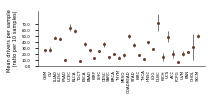

In [23]:
order = list(dict_excess_sample_aggregated.keys())
values = []
ci_ls = []
ci_us = []
for ttype in order:
    mean_excess = np.nanmean(dict_excess_sample_aggregated[ttype])
    values.append(mean_excess)
    ci = get_ci95(dict_excess_sample_aggregated[ttype])
    ci_l = ci[0]
    ci_ls.append(mean_excess-ci_l)
    ci_u = ci[1]
    ci_us.append(ci_u-mean_excess)
fig,ax = plt.subplots(figsize=(3,1))
xs = range(0,len(order))

ax.errorbar(xs, values, yerr=[ci_ls,ci_us], ecolor='grey', capthick=5,fmt='o',elinewidth=1,markersize=2,c="#6c3e31ff" )
#ax.scatter(x=xs,y=values,s=5)
ax.set_xticks(xs)
_=ax.set_xticklabels(order,fontsize=5,rotation=90)
ax.set_yticks(np.arange(0,8,1.0))
ax.set_yticklabels([x*10 for x in np.arange(0,8,1.0)],fontsize=4,)
ax.set_ylabel("Mean drivers per sample \n (ratio per 10 samples)",fontsize=5)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.02 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"n_drivers_per_tumor_total_drivers.pdf"),bbox_inches="tight",dpi=100)

### Global analysis

In [24]:
missense_drivers = list(dict_excess_sample_missense.values())
mean_missense = np.nanmean(list(itertools.chain(*missense_drivers)))
ci_l_m,ci_u_m = get_ci95(list(itertools.chain(*missense_drivers)))
nonsense_drivers = list(dict_excess_sample_nonsense.values())
mean_nonsense = np.nanmean(list(itertools.chain(*nonsense_drivers)))
ci_l_n,ci_u_n = get_ci95(list(itertools.chain(*nonsense_drivers)))
splice_drivers = list(dict_excess_sample_splice.values())
mean_splice = np.nanmean(list(itertools.chain(*splice_drivers)))
ci_l_s,ci_u_s = get_ci95(list(itertools.chain(*splice_drivers)))

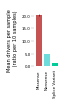

In [25]:
fig,ax = plt.subplots(figsize=(0.45,1.0))
ax.bar(x=0,bottom=0,height=mean_missense,color="#c65353",lw=0.5,yerr=[[mean_missense-ci_l_m,ci_u_m-mean_missense]],error_kw={"linewidth":0.5})
ax.bar(x=1,bottom=0,height=mean_nonsense,color="#70dbdb",lw=0.5,yerr=[[mean_nonsense-ci_l_n,ci_u_n-mean_nonsense]],error_kw={"linewidth":0.5})
ax.bar(x=2,bottom=0,height=mean_splice,color="#00cc99",lw=0.5,yerr=[[mean_splice-ci_l_s,ci_u_s-mean_splice]],error_kw={"linewidth":0.5})



maxv=0.15
ax.set_yticks([x for x in np.arange(0,2.5,0.5)])
ax.set_yticklabels([x*10 for x in np.arange(0,2.5,0.5)],fontsize=4)
ax.set_ylabel("Mean drivers per sample \n (ratio per 10 samples)",fontsize=5)
ax.set_xlabel("",fontsize=5)
ax.set_xticks([0,1,2])
ax.set_xticklabels(["Missense","Nonsense","Splice Variant"],fontsize=5,rotation=90)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(0.0)
ax.tick_params(axis = 'y', labelsize =4  , pad=0.15 ,width=0.15)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.05 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"number_drivers_per_consequence_total_drivers.pdf"),bbox_inches="tight",dpi=100)
None

### Ratio of driver elements with alterations in UPS

##### For each sample get the number of driver alterations in E3 ligases and degrons

##### First create a dictionary per sample 

In [26]:
dict_samples_detail= {}
for filef in glob.glob(path_input_muts+"/"+"*_dndscv.tsv.gz"):
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    ttype = os.path.basename(filef).split(".")[0].split("_")[0]
    df["Cancer_Type"]=ttype
    dict_samples_detail[ttype] = {}
    for sample in df["sampleID"].unique():
        dict_samples_detail[ttype][sample] = 0
    


### Get dictionary of total drivers per sample

In [27]:
dict_samples_drivers = dict_samples_local

### Read dictionary E3 ligases and degrons

In [28]:
path_dictionary_samples_e3

'../../data/dict_excess_per_sample_E3s.json'

In [29]:
dict_samples_e3 = json.load(open(path_dictionary_samples_e3,'r'))
dict_samples_degrons = json.load(open(path_dictionary_samples_degron,'r'))

##### For each sample compute the ratio

In [30]:
dict_ratios = {}
for ttype in dict_samples_detail:
    if ttype == "COAD" or ttype == "READ":
        continue
    dict_ratios[ttype] = []
    for sample in dict_samples_drivers[ttype]:
        total = dict_samples_drivers[ttype][sample]
        if total > 0.0:
            ub = 0.0
            if sample in dict_samples_e3[ttype]:
                ub = ub + dict_samples_e3[ttype][sample]
            if ttype in dict_samples_degrons and sample in dict_samples_degrons[ttype]:
                ub = ub + dict_samples_degrons[ttype][sample]
                
            ratio = float(ub) / float(total)
            dict_ratios[ttype].append(ratio)
    # Samples with only excess in degron mutations
    for sample in dict_samples_degrons[ttype]:
        if not sample in dict_samples_drivers[ttype]:
            dict_ratios[ttype].append(dict_samples_degrons[ttype][sample])

    
    

In [31]:
for ttype in dict_ratios:
    print (ttype,np.nanmean(dict_ratios[ttype]),get_ci95(dict_ratios[ttype]))

GBM 0.035157448741260235 (0.02134846983717146, 0.04896642764534901)
OV 0.03394112944255763 (0.013360917417650654, 0.05452134146746461)
LUAD 0.09148290003348247 (0.07865351789246311, 0.10431228217450184)
LUSC 0.1487778785679391 (0.13388822394536118, 0.163667533190517)
PRAD 0.16326318968476203 (0.13014220241363303, 0.19638417695589103)
UCEC 0.13238668580951826 (0.1164228764356148, 0.14835049518342172)
BLCA 0.0729746479041043 (0.06074636976095517, 0.08520292604725342)
TGCT 0.09019499276642376 (0.0321437638824703, 0.1482462216503772)
ESCA 0.08100751707845034 (0.059162844239299586, 0.1028521899176011)
PAAD 0.06614585884697397 (0.04455487235644745, 0.08773684533750048)
KIRP 0.1332118373114185 (0.09568909862290373, 0.17073457599993327)
LIHC 0.14408202796305686 (0.11969153786007006, 0.16847251806604366)
CESC 0.12847508146057549 (0.1007457283668123, 0.15620443455433866)
SARC 0.05801691253891342 (0.029481965951151556, 0.08655185912667528)
BRCA 0.05373551069551105 (0.04149203147598765, 0.06597898

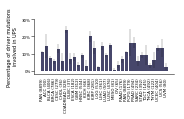

In [32]:
fig,ax = plt.subplots(figsize=(2.5,1.0))
order_original = ["PAN"]+sorted(list(dict_excess_sample_aggregated.keys())[:-1])
i = 0
order = []
for ttype in order_original:
    mean = np.nanmean(dict_ratios[ttype])
    ci_l,ci_u = get_ci95(dict_ratios[ttype])
    ax.bar(x=i,bottom=0,height=mean,color="#47476b",lw=0.3,yerr=[[mean-ci_l,ci_u-mean]],error_kw={"linewidth":0.25})
    order.append(ttype)
    i = i +1

maxv=0.5
ax.set_yticks([x for x in np.arange(0,0.4,0.1)])
ax.set_yticklabels([str(x)+"%" for x in np.arange(0,40,10)],fontsize=4)
ax.set_ylabel("Percentage of driver mutations \n involved in UPS",fontsize=5)
ax.set_xlabel("",fontsize=5)
ax.set_xticks([x for x in range(len(dict_ratios.keys()))])
labels = [x+f" ({len(dict_excess_sample_aggregated[x])})" for x in order]
_=ax.set_xticklabels(labels,fontsize=5,rotation=90)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none') 
ax.tick_params(axis = 'y', labelsize =4  , pad=0.05 ,width=0.5)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.00 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"ratio_drivers.pdf"),bbox_inches="tight",dpi=100)
None